In [1]:
import os
import sys
import gc
import torch
import numpy as np
import healpy as hp
from glob import glob
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [33]:
from scripts.models.threeconv import ThreeConv
from scripts.maploader.maploader import get_data_from_params, get_normalized_from_params, get_log2linear_transform
from scripts.utils.run_utils import setup_trainer, set_params

In [4]:
pl.seed_everything(1234)
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
params = set_params(base_dir, model="threeconv")

[rank: 0] Global seed set to 1234


In [5]:
# Load data
lr, hr = get_data_from_params(params)
data_input, data_condition, transforms_lr, inverse_transform_lr, transforms_hr, inverse_transforms_hr, range_min_lr, range_max_lr, range_min_hr, range_max_hr = get_normalized_from_params(lr, hr, params)

LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/.  Number of maps: 100
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/.  Number of maps: 100
data nside: 512, divided into 48 patches, each patch has 65536 pixels.
LR data normalized to [-1.0,1.0] by both transform.
HR data normalized to [-1.0,1.0] by both transform.


In [23]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
version = 2
ckpt_path = glob(f"{params['train']['save_dir']}{params['train']['log_name']}/version_{version}/checkpoints/*.ckpt")[-1]

In [24]:
model = ThreeConv(params).to(device)
model.load_state_dict(torch.load(ckpt_path)["state_dict"], strict=False)
model.eval()

ThreeConv(
  (conv_in): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (conv_mid): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (conv_out): SphericalChebConv(
    (chebconv): ChebConv()
  )
  (norm_in): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_mid): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Mish()
  (loss_fn): MSELoss()
)

In [25]:
map_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/threeconv/"
if not os.path.exists(map_dir):
    os.makedirs(map_dir)

In [46]:
PATCH_SIZE = 12 * (params['data']['order'])**2
BATCH_SIZE = params['train']['batch_size'] * 2
print(PATCH_SIZE, BATCH_SIZE)

48 12


In [40]:
for j in range(params['data']['n_maps']):
    with torch.no_grad():
        for i in range(int(PATCH_SIZE/BATCH_SIZE)):
            tmp_lr = data_condition[i*BATCH_SIZE:(i+1)*BATCH_SIZE].to(device)
            pred = model(tmp_lr)
            pred = inverse_transforms_hr(pred)
            pred = np.hstack(pred.detach().cpu().numpy()[:,:,0])
            np.save(map_dir+f"threeconv_{str(j).zfill(3)}_batch{str(i).zfill(2)}.npy", pred)
            print(f"data {j}, batch {i} saved.")
            del pred, tmp_lr
            torch.cuda.empty_cache()
            gc.collect()

data 0, batch 0 saved.
data 0, batch 1 saved.
data 0, batch 2 saved.
data 0, batch 3 saved.
data 1, batch 0 saved.
data 1, batch 1 saved.
data 1, batch 2 saved.
data 1, batch 3 saved.
data 2, batch 0 saved.
data 2, batch 1 saved.
data 2, batch 2 saved.
data 2, batch 3 saved.
data 3, batch 0 saved.
data 3, batch 1 saved.
data 3, batch 2 saved.
data 3, batch 3 saved.
data 4, batch 0 saved.
data 4, batch 1 saved.
data 4, batch 2 saved.
data 4, batch 3 saved.
data 5, batch 0 saved.
data 5, batch 1 saved.
data 5, batch 2 saved.
data 5, batch 3 saved.
data 6, batch 0 saved.
data 6, batch 1 saved.
data 6, batch 2 saved.
data 6, batch 3 saved.
data 7, batch 0 saved.
data 7, batch 1 saved.
data 7, batch 2 saved.
data 7, batch 3 saved.
data 8, batch 0 saved.
data 8, batch 1 saved.
data 8, batch 2 saved.
data 8, batch 3 saved.
data 9, batch 0 saved.
data 9, batch 1 saved.
data 9, batch 2 saved.
data 9, batch 3 saved.
data 10, batch 0 saved.
data 10, batch 1 saved.
data 10, batch 2 saved.
data 10,

In [41]:
# load all saved maps
pred = []
for j in range(params['data']['n_maps']):
    pred_batch = []
    for i in range(int(PATCH_SIZE/BATCH_SIZE)):
        pred_batch.append(np.load(map_dir+f"threeconv_{str(j).zfill(3)}_batch{str(i).zfill(2)}.npy"))
    pred.append(np.hstack(pred_batch))

In [42]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

In [48]:
np.vstack(pred).shape

(100, 3145728)

In [44]:
tmp_lr = np.hstack(inverse_transform_lr(data_condition).detach().cpu().numpy()[:PATCH_SIZE,:,0])
tmp_hr = np.hstack(inverse_transforms_hr(data_input).detach().cpu().numpy()[:PATCH_SIZE,:,0])

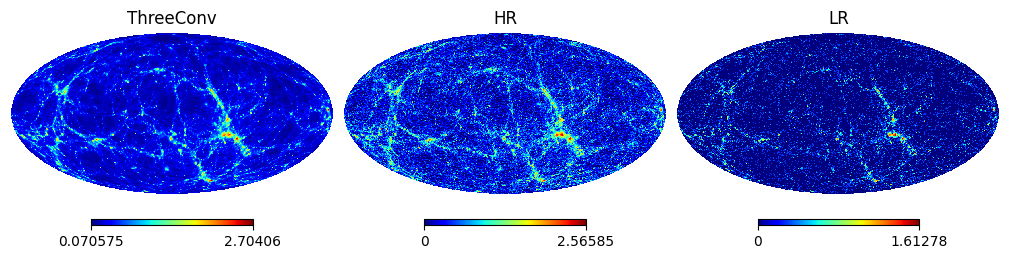

In [50]:
# plot healpix map
fig = plt.figure(figsize=(10, 5))
hp.mollview(pred[0], 
            title="ThreeConv", 
            cmap="jet", 
            nest=True, 
            sub=(1, 3, 1))

hp.mollview(tmp_hr,
            title="HR", 
            cmap="jet", 
            nest=True, 
            sub=(1, 3, 2))

hp.mollview(tmp_lr,
            title="LR", 
            cmap="jet", 
            nest=True, 
            sub=(1, 3, 3))

In [ ]:
log2linear_transform, inverse_log2linear_transform = get_log2linear_transform()

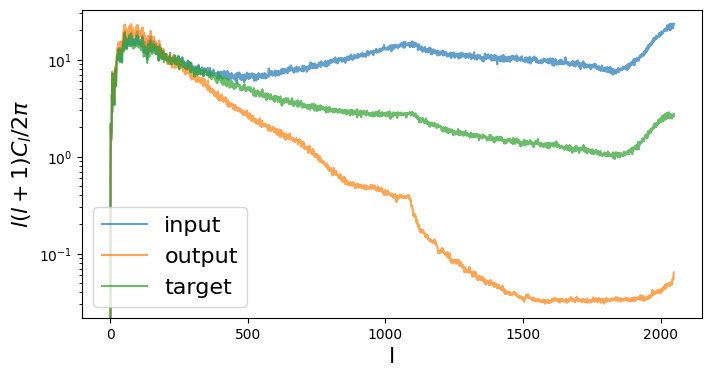

In [51]:
lmax = int(3/2 * params['data']['nside'])
input_cl =hp.sphtfunc.anafast(t2hpr(log2linear_transform(tmp_lr)), lmax=lmax) * 8**2
target_cl =hp.sphtfunc.anafast(t2hpr(log2linear_transform(tmp_hr)), lmax=lmax)
pred_cl =np.mean([hp.sphtfunc.anafast(t2hpr(log2linear_transform(predi)), lmax=lmax) for predi in pred], axis=0)
cls = [input_cl, pred_cl, target_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
labels = ["input", "output", "target"]

ell = np.arange(len(cls[0]))
for cl, label in zip(cls, labels):
    ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
ax.set_xlabel("l", fontsize=16)
ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=16)
ax.set_yscale("log")
ax.legend(fontsize=16)

plt.show()